### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [4]:
%matplotlib inline

In [5]:
from pathlib import Path
import requests
PATH_file =Path( r'D:\studydata\machine_bild_learn\AI\资料\缺陷检测章节资料\PyTorch基础\2-神经网络实战分类与回归任务\神经网络实战分类与回归任务\data\mnist\mnist.pkl.gz')


In [6]:
import pickle
import gzip

with gzip.open((PATH_file).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [7]:
import tensorflow as tf
print(f"Tensor Flow Version: {tf.__version__}")
from tensorflow import keras
from tensorflow.keras import layers,models

Tensor Flow Version: 2.13.0


784是mnist数据集每个样本的像素点个数

(50000, 784)


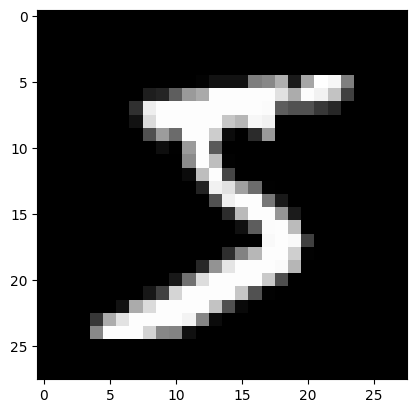

In [8]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

注意数据需转换成tensor才能参与后续建模训练


In [9]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [10]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [11]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(10.6558, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [12]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x
        

In [13]:
net = Mnist_NN()
print(net)


Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [14]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[ 0.0141,  0.0336, -0.0302,  ..., -0.0040,  0.0035,  0.0162],
        [ 0.0156,  0.0322, -0.0043,  ..., -0.0258,  0.0105, -0.0295],
        [ 0.0270,  0.0140,  0.0251,  ..., -0.0003, -0.0130,  0.0099],
        ...,
        [ 0.0311, -0.0210,  0.0095,  ...,  0.0249,  0.0006, -0.0175],
        [-0.0173, -0.0103, -0.0009,  ..., -0.0255,  0.0068, -0.0351],
        [ 0.0249,  0.0070, -0.0012,  ..., -0.0198,  0.0255,  0.0076]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-0.0250,  0.0261, -0.0033,  0.0120,  0.0054,  0.0257,  0.0139,  0.0039,
         0.0341,  0.0046,  0.0030, -0.0227, -0.0068, -0.0064, -0.0169, -0.0293,
        -0.0194,  0.0091, -0.0089,  0.0271,  0.0341,  0.0342,  0.0017, -0.0271,
         0.0344,  0.0003,  0.0098,  0.0205,  0.0186,  0.0024, -0.0205, -0.0125,
        -0.0058, -0.0022,  0.0229,  0.0258, -0.0048, -0.0225,  0.0263, -0.0046,
        -0.0238,  0.0041,  0.0010, -0.0110, 

### 使用TensorDataset和DataLoader来简化

In [15]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [16]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [17]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [18]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [19]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

### 三行搞定！

In [20]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：2.2744764854431154
当前step:1 验证集损失：2.2337563312530517
当前step:2 验证集损失：2.169186508178711
当前step:3 验证集损失：2.066862322998047
当前step:4 验证集损失：1.911208521461487
当前step:5 验证集损失：1.6935717069625855
当前step:6 验证集损失：1.4369251892089843
当前step:7 验证集损失：1.1991585998535157
当前step:8 验证集损失：1.014420185661316
当前step:9 验证集损失：0.8793546689033508
当前step:10 验证集损失：0.7802110612869263
当前step:11 验证集损失：0.7035645777702332
当前step:12 验证集损失：0.644445543384552
当前step:13 验证集损失：0.5972626617431641
当前step:14 验证集损失：0.5589185689926147
当前step:15 验证集损失：0.5278028427124023
当前step:16 验证集损失：0.5011459625720978
当前step:17 验证集损失：0.47938022832870486
当前step:18 验证集损失：0.46068551354408266
当前step:19 验证集损失：0.4446502345561981
当前step:20 验证集损失：0.43097188382148743
当前step:21 验证集损失：0.41868391275405886
当前step:22 验证集损失：0.407663818359375
当前step:23 验证集损失：0.3982532854318619
当前step:24 验证集损失：0.3896841794013977
